In [1]:
import sys
import os.path
import itertools
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.metrics
import keras.optimizers
import keras.callbacks
import keras.utils.np_utils
import keras.preprocessing.sequence
from keras.objectives import categorical_crossentropy
import warnings
warnings.filterwarnings('ignore')
import LSTM_tools as tools
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
data_path = 'data'
if not os.path.exists(data_path):
    os.mkdir(data_path)
plot_path = 'plots'
if not os.path.exists(plot_path):
    os.mkdir(plot_path)    
model_path = 'models'
if not os.path.exists(model_path):
    os.mkdir(model_path)

Using TensorFlow backend.


In [2]:
## Settings
'''Keep merge_data=True if you have set n_classes (in preprocessing) such that 
there are classes in the test set that do not have instances in the training set'''
merge_data = True 
sn = 3
'''This means that we are using all the features, 
if you want to limit the model to use only a subset of proncipal components, give them to this parameter as a list.
The list should always include "id", "cycle", "status" columns'''
usecols = None
setnumber = 'FD00' + str(sn)
data_path = 'data'
plot_path = 'plots'
model_path = 'models'

## LSTM settings
n_in = 60
n_out = 1
dropout = 0.2
bs = 1000 #batch size-Note that smaller batch sizes lead to [considerably] longer training times
epochs = 50
LSTM_units = 8

maxlen: 525
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 1, 525)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 17088     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
Total params: 17,156
Trainable params: 17,140
Non-trainable params: 16
_________________________________________________________________
None


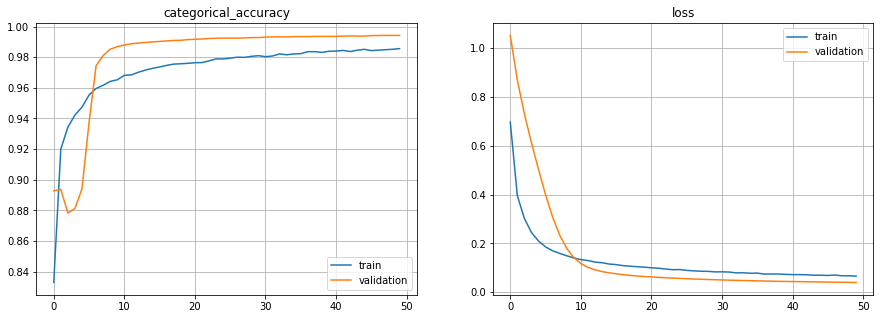

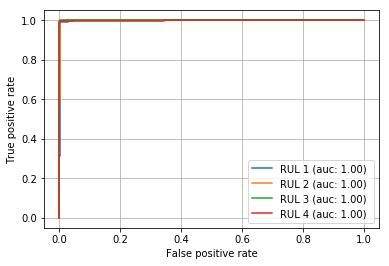

             precision    recall  f1-score   support

          0       0.98      0.97      0.97      1080
          1       0.99      0.99      0.99      3761
          2       0.98      1.00      0.99       861
          3       1.00      1.00      1.00     12898

avg / total       0.99      0.99      0.99     18600



In [3]:
train, test, validate = tools.read_preprocessed_data(setnumber, usecols, merge_data)
X_train, y_train, X_test, y_test, X_validate, y_validate = tools.prepare_data_for_LSTM(train, test, validate, n_in=n_in, n_out=n_out)
y_train_bin = keras.utils.np_utils.to_categorical(y_train)
y_test_bin = keras.utils.np_utils.to_categorical(y_test)
y_validate_bin = keras.utils.np_utils.to_categorical(y_validate)
lw = X_train.shape[1]
n_classes = max(train.status.nunique(), validate.status.nunique())
# create the model
model = keras.models.Sequential()
model.add(keras.layers.Masking(mask_value=-1, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.LSTM(
    LSTM_units,
    input_shape=(X_train.shape[1], X_train.shape[2]),
    unroll=False,
#    return_sequences=True
))
model.add(keras.layers.Dropout(dropout))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(n_classes, activation='softmax'))
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=[keras.metrics.categorical_accuracy])
print(model.summary())
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train_bin, epochs=epochs, batch_size=bs,
                    validation_data=(X_validate, y_validate_bin),
                    verbose=0, shuffle=True,
                    callbacks=[early_stopping])
#model.save(os.path.join(model_path, 'LSTM_model_%s_%d_%.1f_nin_%d.h5'%(setnumber, LSTM_units, dropout, n_in)))
tools.plot_learning_curve(history, merge_data)
plt.show()
aucs, y_pred = tools.make_prediction(model, X_test, y_test_bin, fig=True)
target_names = ['class 0', 'class 1', 'class 2', 'class3']
y_pred_bin = keras.utils.np_utils.to_categorical(np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))]),
                                                 num_classes=train.status.nunique())
print (sklearn.metrics.classification_report(y_test_bin, y_pred_bin))